In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998732,0.996949,0.134761,10000.001268
1,9999.996849,0.997237,0.134800,10000.003151
2,9999.994966,0.997245,0.134802,10000.005034
3,9999.993083,0.996937,0.134760,10000.006917
4,9999.991199,0.997067,0.134778,10000.008801
...,...,...,...,...
3001255,4347.829323,0.944661,0.015909,22999.982882
3001256,4347.827440,0.938258,0.015800,22999.992845
3001257,4347.825556,0.934484,0.015736,23000.002807
3001258,4347.823673,0.930303,0.015666,23000.012770


In [4]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visible range\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
614,10425.8870
615,10426.6020
616,10535.1220
617,10580.0390


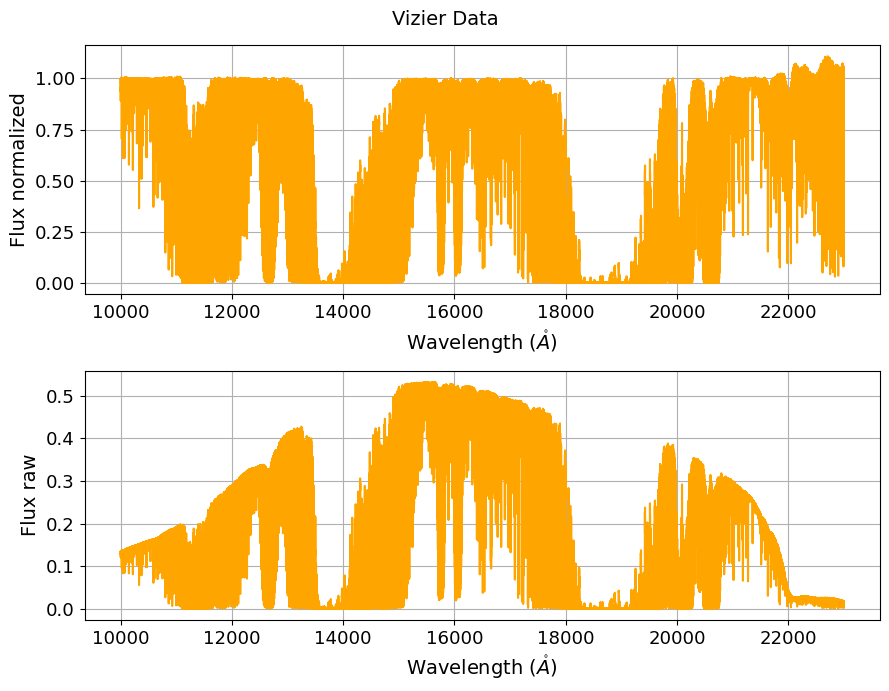

In [5]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Wavelength classification

In [ ]:
#between work like < or > but not the equal, reset the index for the other functions
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
data_11000_12000 = raw_data[raw_data['Wave A'].between(11000, 12000, inclusive='neither')].reset_index(drop=True)
data_12000_13000 = raw_data[raw_data['Wave A'].between(12000, 13000, inclusive='neither')].reset_index(drop=True)
data_13000_14000 = raw_data[raw_data['Wave A'].between(13000, 14000, inclusive='neither')].reset_index(drop=True)
data_14000_15000 = raw_data[raw_data['Wave A'].between(14000, 15000, inclusive='neither')].reset_index(drop=True)
data_15000_16000 = raw_data[raw_data['Wave A'].between(15000, 16000, inclusive='neither')].reset_index(drop=True)
data_16000_17000 = raw_data[raw_data['Wave A'].between(16000, 17000, inclusive='neither')].reset_index(drop=True)
data_17000_18000 = raw_data[raw_data['Wave A'].between(17000, 18000, inclusive='neither')].reset_index(drop=True)
data_18000_19000 = raw_data[raw_data['Wave A'].between(18000, 19000, inclusive='neither')].reset_index(drop=True)
data_19000_20000 = raw_data[raw_data['Wave A'].between(19000, 20000, inclusive='neither')].reset_index(drop=True)
data_20000_21000 = raw_data[raw_data['Wave A'].between(20000, 21000, inclusive='neither')].reset_index(drop=True)
data_21000_22000 = raw_data[raw_data['Wave A'].between(21000, 22000, inclusive='neither')].reset_index(drop=True)
data_22000_23000 = raw_data[raw_data['Wave A'].between(22000, 23000, inclusive='neither')].reset_index(drop=True)

data_18000_19000

,Wave (cm),nFlux,rFlux,Wave A
0,5555.554433,0.001446,0.000672,18000.003638
1,5555.552549,0.001507,0.000701,18000.009740
2,5555.550666,0.001631,0.000758,18000.015842
3,5555.548783,0.001799,0.000836,18000.021944
4,5555.546900,0.001839,0.000855,18000.028045
...,...,...,...,...
155256,5263.165677,0.001592,0.000689,18999.971905
155257,5263.163794,0.001293,0.000560,18999.978703
155258,5263.161911,0.001108,0.000479,18999.985502
155259,5263.160028,0.001212,0.000524,18999.992300


In [7]:
#Now from lambda
lambda_10000_11000 = raw_lambda[raw_lambda['Nave list'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
lambda_11000_12000 = raw_lambda[raw_lambda['Nave list'].between(11000, 12000, inclusive='neither')].reset_index(drop=True)
lambda_12000_13000 = raw_lambda[raw_lambda['Nave list'].between(12000, 13000, inclusive='neither')].reset_index(drop=True)
lambda_13000_14000 = raw_lambda[raw_lambda['Nave list'].between(13000, 14000, inclusive='neither')].reset_index(drop=True)
lambda_14000_15000 = raw_lambda[raw_lambda['Nave list'].between(14000, 15000, inclusive='neither')].reset_index(drop=True)
lambda_15000_16000 = raw_lambda[raw_lambda['Nave list'].between(15000, 16000, inclusive='neither')].reset_index(drop=True)
lambda_16000_17000 = raw_lambda[raw_lambda['Nave list'].between(16000, 17000, inclusive='neither')].reset_index(drop=True)
lambda_17000_18000 = raw_lambda[raw_lambda['Nave list'].between(17000, 18000, inclusive='neither')].reset_index(drop=True)
lambda_18000_19000 = raw_lambda[raw_lambda['Nave list'].between(18000, 19000, inclusive='neither')].reset_index(drop=True)
lambda_19000_20000 = raw_lambda[raw_lambda['Nave list'].between(19000, 20000, inclusive='neither')].reset_index(drop=True)
lambda_20000_21000 = raw_lambda[raw_lambda['Nave list'].between(20000, 21000, inclusive='neither')].reset_index(drop=True)
lambda_21000_22000 = raw_lambda[raw_lambda['Nave list'].between(21000, 22000, inclusive='neither')].reset_index(drop=True)
lambda_22000_23000 = raw_lambda[raw_lambda['Nave list'].between(22000, 23000, inclusive='neither')].reset_index(drop=True)


lambda_15000_16000

,Nave list


### Find the minimums and the closer line of the Fe I line


In [9]:
# #Find the minimum or the lambda in the spectrum
# def find_minimums(wave,flux,lamda):
#     #The function find_peaks just got the index of the points
#     #The minus if for the minimums, without it are the maximums
#     minimums,_ = find_peaks(-flux) 
#     mindf = pd.DataFrame([]) #Make a dataframe
#     mindf['min_wave'] = wave[minimums]
#     mindf['min_flux'] = flux[minimums]

#     #Take the closer line with the absolute value of the difference between the minimums and the line
#     #This step dont include the closer points that are not minimums
#     closer = []
#     for each in lamda:
#         mindf['abs'] = np.abs(mindf['min_wave']-each)
#         closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #take all the row

#     #Dataframe with the marks for the closer lines of Fe
#     closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
#     closer_data['Fe line'] = lamda

#     return closer_data.drop(['abs'],axis=1)

# #Closer lines
# closer_lines_10000_11000 = find_minimums(data_10000_11000['Wave A'],data_10000_11000['nFlux'],lambda_10000_11000['Nave list'])
# closer_lines_11000_12000 = find_minimums(data_11000_12000['Wave A'],data_11000_12000['nFlux'],lambda_11000_12000['Nave list'])
# closer_lines_12000_13000 = find_minimums(data_12000_13000['Wave A'],data_12000_13000['nFlux'],lambda_12000_13000['Nave list'])
# closer_lines_13000_14000 = find_minimums(data_13000_14000['Wave A'],data_13000_14000['nFlux'],lambda_13000_14000['Nave list'])
# closer_lines_14000_15000 = find_minimums(data_14000_15000['Wave A'],data_14000_15000['nFlux'],lambda_14000_15000['Nave list'])
# closer_lines_15000_16000 = find_minimums(data_15000_16000['Wave A'],data_15000_16000['nFlux'],lambda_15000_16000['Nave list'])
# closer_lines_16000_17000 = find_minimums(data_16000_17000['Wave A'],data_16000_17000['nFlux'],lambda_16000_17000['Nave list'])
# closer_lines_17000_18000 = find_minimums(data_17000_18000['Wave A'],data_17000_18000['nFlux'],lambda_17000_18000['Nave list'])
# closer_lines_18000_19000 = find_minimums(data_18000_19000['Wave A'],data_18000_19000['nFlux'],lambda_18000_19000['Nave list'])
# closer_lines_19000_20000 = find_minimums(data_19000_20000['Wave A'],data_19000_20000['nFlux'],lambda_19000_20000['Nave list'])
# closer_lines_20000_21000 = find_minimums(data_20000_21000['Wave A'],data_20000_21000['nFlux'],lambda_20000_21000['Nave list'])
# closer_lines_21000_22000 = find_minimums(data_21000_22000['Wave A'],data_21000_22000['nFlux'],lambda_21000_22000['Nave list'])
# closer_lines_22000_23000 = find_minimums(data_22000_23000['Wave A'],data_22000_23000['nFlux'],lambda_22000_23000['Nave list'])

In [10]:
# fig3, ax = plt.subplots(1,1,figsize=(22,7))
# ax.plot(data_22000_23000['Wave A'],data_22000_23000['nFlux'], color='orange')
# ax.scatter(closer_lines_22000_23000['min_wave'],closer_lines_22000_23000['min_flux'], color='blue')
# ax.set_title('Vizier Data closer lines')
# ax.set_xlabel(r'Wavelength $(\mathring{A})$')
# ax.set_ylabel('Flux')
# ax.grid()

In [ ]:
# #Localize the line and save the width for lines
# def width_minimums(closer_lines,data,width):
#     local_points =[]
#     for each in closer_lines['min_wave']:
#         #This append all the part of the dataframe in that range
#         local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

#     return local_points

# #Data
# local_points_10000_11000 = width_minimums(closer_lines_10000_11000,data_10000_11000,0.05)
# local_points_11000_11000 = width_minimums(closer_lines_11000_12000,data_10000_11000,0.05)
# local_points_12000_13000 = width_minimums(closer_lines_12000_13000,data_10000_11000,0.05)
# local_points_13000_14000 = width_minimums(closer_lines_13000_14000,data_10000_11000,0.05)
# local_points_14000_15000 = width_minimums(closer_lines_14000_15000,data_10000_11000,0.05)
# local_points_15000_16000 = width_minimums(closer_lines_15000_16000,data_10000_11000,0.05)
# local_points_16000_17000 = width_minimums(closer_lines_16000_17000,data_10000_11000,0.05)
# local_points_17000_18000 = width_minimums(closer_lines_17000_18000,data_10000_11000,0.05)
# local_points_18000_19000 = width_minimums(closer_lines_18000_19000,data_10000_11000,0.05)
# local_points_19000_20000 = width_minimums(closer_lines_19000_20000,data_10000_11000,0.05)
# local_points_20000_21000 = width_minimums(closer_lines_20000_21000,data_10000_11000,0.05)
# local_points_21000_22000 = width_minimums(closer_lines_21000_22000,data_10000_11000,0.05)
# local_points_22000_23000 = width_minimums(closer_lines_22000_23000,data_10000_11000,0.05)

### Derivates and fit

In [13]:
# def Fit_derivates(local_points,lamda_list):
#     values = []
#     fit = []

#     for i in range(0,len(local_points)):

#         data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

#         #Internal rise, with the mean and std just for the big data (wavenumber)
#         wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
#         wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division

#         #Polynomial Fit is better for numerical aproximation than polyfit
#         pol = Polynomial.fit(wave_scaled, data_flux, 4)

#         #Scaled coeficients of fit
#         param = pol.convert().coef

#         #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
#         d_param = poly.polyder(param) #First
#         d2_param = poly.polyder(d_param) #Second
#         d3_param = poly.polyder(d2_param) #Third

#         #The fit values
#         flux_fit = poly.polyval(wave_scaled,param)

#         #Find the minimum with the regression and derivates
#         roots = poly.polyroots(d_param).real #roots or critical points
#         valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#check with the second derivate, just positive values for minimums
        
#         if valid_roots.size >0:
#             value_roots = pol(valid_roots) #evaluate in the polinomium for the global minimum
#             minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #take the values

#             #For the lambda convert the minimal root in wave with the scale of the mean, we dont scale the flux data
#             lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

#             #Evaluate the second and third derivate in the lambda observed
#             #Formula for the third derivate
#             def Third_Derivate(second, third):
#                 return -((third)/(3*(second**2)))

#             d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
#             d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

#             #Calculate the velocity and convective blueshift
#             blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
#             velocity = round((blueshift) - 633) #Formula for relativistic aproximation

    
#             values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) #natural lambda, observed lambda, flux, velocity, second derivate, third derivate

#             fit.append(flux_fit)

#     Values =  pd.concat(values,axis=0).reset_index(drop=True)

#     Values.columns = ["Lambda natural", "Lambda observed", "Flux",'Velocity','2nd Derivate','3rd Derivate','Blueshift']


#     return Values

# #Values
# Values_10000_11000 = Fit_derivates(local_points_10000_11000,lambda_10000_11000['Nave list'])
# Values_11000_12000 = Fit_derivates(local_points_11000_12000,lambda_10000_11000['Nave list'])
# Values_12000_13000 = Fit_derivates(local_points_12000_13000,lambda_10000_11000['Nave list'])
# Values_13000_14000 = Fit_derivates(local_points_13000_14000,lambda_10000_11000['Nave list'])
# Values_14000_15000 = Fit_derivates(local_points_14000_15000,lambda_10000_11000['Nave list'])
# Values_15000_16000 = Fit_derivates(local_points_15000_16000,lambda_10000_11000['Nave list'])
# Values_16000_17000 = Fit_derivates(local_points_16000_17000,lambda_10000_11000['Nave list'])
# Values_17000_18000 = Fit_derivates(local_points_17000_18000,lambda_10000_11000['Nave list'])
# Values_18000_19000 = Fit_derivates(local_points_18000_19000,lambda_10000_11000['Nave list'])
# Values_19000_20000 = Fit_derivates(local_points_19000_20000,lambda_10000_11000['Nave list'])
# Values_20000_21000 = Fit_derivates(local_points_20000_21000,lambda_10000_11000['Nave list'])
# Values_21000_22000 = Fit_derivates(local_points_21000_22000,lambda_10000_11000['Nave list'])
# Values_22000_23000 = Fit_derivates(local_points_22000_23000,lambda_10000_11000['Nave list'])

# Values_22000_23000 

## Visualizer for Fe lines with the fit

In [ ]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values,fit):
#         self.root = root
#         self.root.title("Visualizador Interactivo de Outliers")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Índice de Outlier:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Anterior", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Siguiente →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     #Graficas
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
        
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.local_points[j]['nFlux'],
#             color='orange',
#             label='Espectro'
#         )
        
#         #Closer lines
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.fit[j],
#             color='blue',
#             label='Fit',
#             marker='.',
#         )
        
#         #Puntos de la lista de Fe
#         self.ax.scatter(
#             self.values['Lambda observed'][j],
#             self.values['Flux'][j],
#             color='blue',
#             label='lambda',
#             s=100
#         )
        
#         #Vainitas del gráfico
#         self.ax.set_title(f'Visualizer - Índice {self.index[j]}')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")

#     app = OutlierViewer(root, local_points_9000_10000, Values_9000_10000,fit)

#     root.mainloop()

In [ ]:
# Values = pd.concat([Values_10000_11000, Values_11000_12000, Values_12000_13000, Values_13000_14000,
#                     Values_14000_15000, Values_15000_16000, Values_16000_17000, Values_17000_18000,
#                     Values_18000_19000,, Values_19000_20000, Values_20000_21000 ,Values_21000_22000, 
#                     Values_22000_23000],axis=0).reset_index(drop=True)


In [ ]:
#Convert to excel
# Values.to_excel('valores_NIR.xlsx', index=False)

### Graphics 

In [ ]:
# #Velocity vs Flux 
# fig5, ax = plt.subplots(1,1,figsize=(10,6))

# ax.scatter(Values['Flux'],Values['Velocity'],color='brown')
# ax.set_title('Velocity vs Flux normalized')
# ax.set_xlabel(r'Flux')
# ax.set_ylabel('Velocity (m/s)')
# ax.grid()
# # fig5.savefig('Velocity.png')

In [15]:
# #2nd Derivate vs Flux
# fig6, ax = plt.subplots(1,1,figsize=(10,6))

# ax.scatter(Values['Flux'],Values['2nd Derivate'], color='brown')
# ax.set_title('2nd Derivate vs Flux normalized')
# ax.set_xlabel(r'Flux')
# ax.grid()
# # fig6.savefig('2Derivate.png')

In [16]:
# #3rd Derivate vs Flux
# fig7, ax = plt.subplots(1,1,figsize=(10,6))

# ax.scatter(Values['Flux'],Values['3rd Derivate'], color='brown')
# ax.set_title('3rd Derivate relation vs Flux normalized')
# ax.set_xlabel(r'Flux')
# ax.grid()
# # fig7.savefig('3Derivate.png')

In [ ]:
# #Granulation pattern
# fig8, ax = plt.subplots(1,1,figsize=(10,6))

# ax.scatter(1-Values['Flux'],Values['Blueshift'], color='brown')
# ax.set_title('Blueshift vs Normalized line depth')
# ax.set_xlabel(r'Line Depth')
# ax.set_ylabel(r'Blueshift')
# ax.grid()
# # fig8.savefig('Blueshift.png')